In [112]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient

from qiskit.circuit.library import QFT, RealAmplitudes, TwoLocal, EfficientSU2
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit_nature.runtime import VQEClient

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.tools.visualization import circuit_drawer

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeManila

#from qiskit.aqua.components.initial_states import VarFormBased, Custom
# Import useful packages

import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Noisy simulator
backend_aer = Aer.get_backend('aer_simulator')
device_backend=FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
#Real Devices
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
sh=1024
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()


ibmqfactory.load_account:WARNING:2022-05-16 12:21:37,113: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [213]:
q=4 #qubits
n=2**q #dimension
coup=0.2 #coupling
alpha=coup/(np.math.factorial(3)) #cubic coupling
#alpha=coup/3
beta=coup/(np.math.factorial(4)) #quartic coupling
#beta=coup/4

In [214]:
#Position Basis

#Position Operator
Xo=np.zeros(shape=(n,n)).astype(complex)
for i in range (n):
    Xo[i][i]=np.sqrt(2*np.pi/(n))*(2*(i+1)-n-1)/2


#Fourier transform
F=np.zeros(shape=(n,n)).astype(complex)
for i in range(n):
    for j in range(n):
        F[i][j]=np.exp(complex(0,2*np.pi/n)*((2*(i+1)-n-1)/2)*((2*(j+1)-n-1)/2))/np.sqrt(n)

#Momentum Operator
P=np.matmul(np.matmul(F.conj().T,Xo),F)

#Harmonic Oscillator
H=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2
H_eigenv=np.sort(np.linalg.eig(H)[0].real) #Eigenvalues

#Cubic Anharmoinic Oscilator
CH=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2 - alpha*np.linalg.matrix_power(Xo,3)
CH_eigenv=np.sort(np.linalg.eig(H)[0].real) #EigenValues

#Quadratic Anharmoinic Oscilator
QH=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2 + beta*np.linalg.matrix_power(Xo,4)
QH_eigenv=np.sort(np.linalg.eig(H)[0].real) #EigenValues

#Ladder operators
A=np.sqrt(1/2)*(Xo+complex(0,1)*P)
A_dag=A.conj().T

In [215]:
#Spectrums

#Harmonic Oscillator Spectrum
HO_eigv=np.empty([n][0])
for i in range(n):
    HO_eigv[i]=i+(1/2)
    
#Cubic Anaharmonic Oscillator Spectrum
CAHO_eigv=np.empty([n][0])
for i in range(n):
    CAHO_eigv[i]=i+(1/2)+(5/12)*coup*((i**2)+i+11/30)
    
#Quartic Anharmonic Oscillator Spectrum    
QAHO_eigv=np.empty([n][0])
for i in range(n):
    QAHO_eigv[i]=i+(1/2)+(3/8)*coup*((i**2)+i+1/2)-(1/64)*(coup**2)*(17*(i**3)+(51/2)*i**2+(59/2)*i+21/2)

In [216]:
#Energy Basis

#Ladder operator and identity
AE = np.zeros(shape=(n,n)).astype(complex)
idt= np.zeros(shape=(n,n)).astype(complex)

for i in range(n+1):
    for j in range(n+1):
        if j-i==1:
            AE[i-1][j-1]=np.sqrt(j-1)
for i in range(n+1):
    for j in range(n+1):
        if j==i:
            idt[i-1][j-1]=1
AE_dag=AE.conj().T

XE=(np.sqrt(1/2))*(AE_dag+AE) #Position Operator
PE=complex(0,np.sqrt(1/2))*(AE_dag-AE) #Momentum Operator
HOE=np.matmul(AE_dag,AE) +(1/2)*idt #Harmonic Oscillator
CAHOE=np.matmul(AE_dag,AE) + ((1/2)*idt) - alpha*np.linalg.matrix_power(XE,3) # Cubic Anaharmonic Oscillator
QAHOE=np.matmul(AE_dag,AE) + ((1/2)*idt) + beta*np.linalg.matrix_power(XE,4) #Quartic Anaharmonic Oscillator

#Eigenvalues
HOE_eigenv=np.linalg.eig(HOE)[0].real
CAHOE_eigenv=np.linalg.eig(CAHOE)[0].real
QAHOE_eigenv=np.linalg.eig(QAHOE)[0].real

    
HOE_eigenv=np.sort(HOE_eigenv)    
CAHOE_eigenv=np.sort(CAHOE_eigenv)
QAHOE_eigenv=np.sort(QAHOE_eigenv)

np.linalg.det(HOE)
np.linalg.det(CAHOE)
np.linalg.det(QAHOE)

(10834295127949.334+0j)

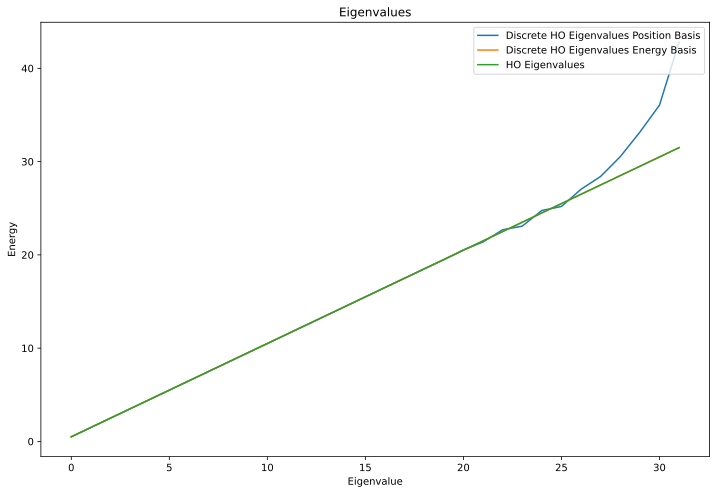

In [173]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), H_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), HOE_eigenv, label='Discrete HO Eigenvalues Energy Basis')
pylab.plot(np.arange(0,n,1), HO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

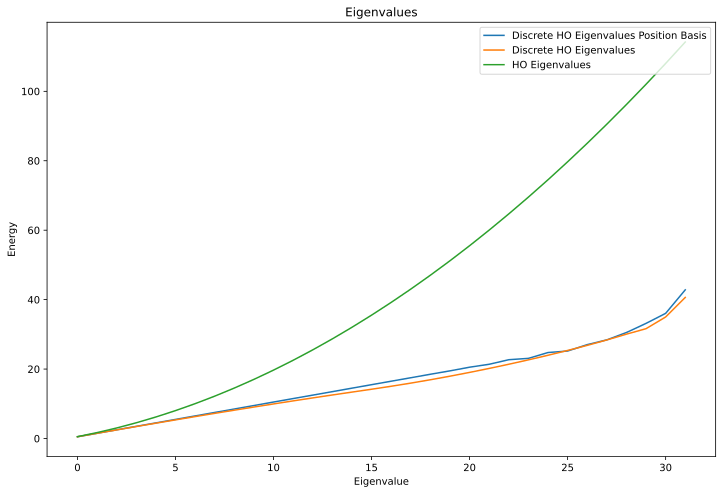

In [174]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), CH_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), CAHOE_eigenv, label='Discrete HO Eigenvalues')
pylab.plot(np.arange(0,n,1), CAHO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

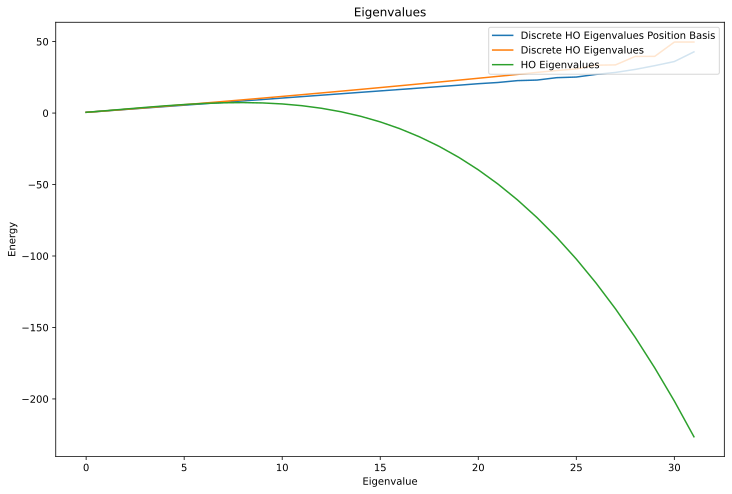

In [175]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), QH_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), QAHOE_eigenv, label='Discrete HO Eigenvalues')
pylab.plot(np.arange(0,n,1), QAHO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

In [236]:
HOE_OP=Operator(HOE) #Qiskit operators
CAHOE_OP=Operator(CAHOE)
QAHOE_OP=Operator(QAHOE)


P_HOE_OP=PauliSumOp(SparsePauliOp.from_operator(HOE_OP),coeff=1.0) #PauliSum OPs
P_CAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(CAHOE_OP),coeff=1.0)
P_QAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(QAHOE_OP),coeff=1.0)


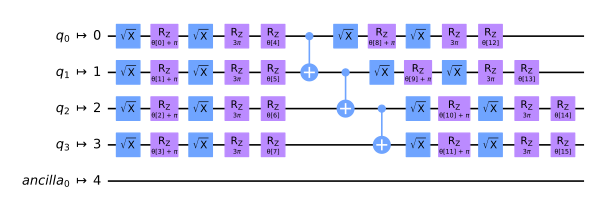

In [235]:
from qiskit.compiler import transpile

vf=EfficientSU2(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )
vf=transpile(vf.decompose(),backend_manil)
vf.draw('mpl',scale=0.8)


In [163]:
#Function for realizing VQE in multiple optimizers and storing values in a dictionary

def VQE_Run(vf,optimizers, qi ,gradient,initial_point,OP):
    
    begin = datetime.now()
    results={}
    for i, optimizer in enumerate(optimizers):
        beginl = datetime.now()
        
        results[type(optimizer).__name__]={}
        counts=[]
        values=[]
        def callback(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
    
        vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback,gradient=gradient,initial_point=initial_point)
        vqe_result=vqe.compute_minimum_eigenvalue(operator=OP)
        results[type(optimizer).__name__]['opt_pt']=vqe_result.optimal_point
        results[type(optimizer).__name__]['eigenvalues']=vqe_result.eigenvalue.real
        results[type(optimizer).__name__]['counts'] = np.asarray(counts)
        results[type(optimizer).__name__]['values'] = np.asarray(values)
        
        endl = datetime.now()
        results[type(optimizer).__name__]['Runtime'] = endl-beginl
    
    end = datetime.now()
    results['Total Runtime']=end-begin
    return results

In [77]:
#define Quantum Instances, Variational Form, optimizers and gradients.

seed = 62
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed) # Ideal Quantum Instance
nois_qi = QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, # Noisy Quantum Instance
                          coupling_map=coupling_map, noise_model=noise_model,)

vf=EfficientSU2( #Variational Form
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )

miter=300
optimizers = [COBYLA(maxiter=miter), L_BFGS_B(maxiter=miter), SLSQP(maxiter=miter), SPSA(maxiter=miter)] # Optimizers

gradients=[Gradient(grad_method='param_shift'),Gradient(grad_method='lin_comb'),Gradient(grad_method='fin_diff')]

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


VQE Results for COBYLA : 0.5000928271042582
VQE Results for L_BFGS_B : 0.5000000000905789
VQE Results for SLSQP : 0.5000000964382523
VQE Results for SPSA : 0.5010899488663612
Exact Result: 0.50000


Total Runtime: 0:00:12.703328
Runtime for  COBYLA : 0:00:00.489396
Runtime for  L_BFGS_B : 0:00:06.859027
Runtime for  SLSQP : 0:00:04.704986
Runtime for  SPSA : 0:00:00.649899


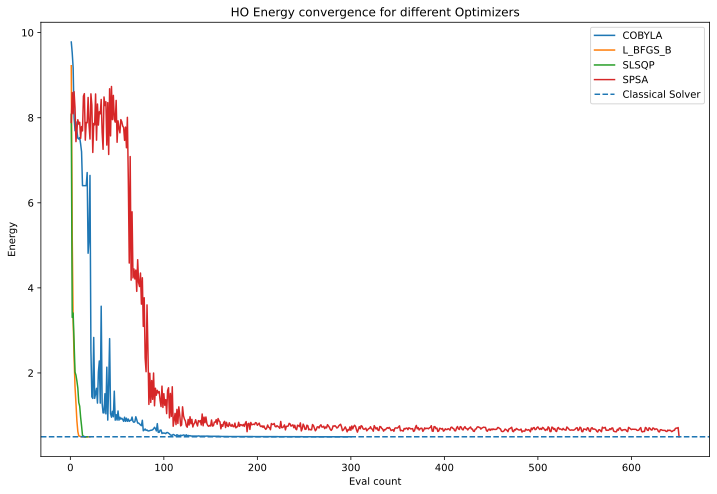

In [13]:
#QHO Statevector simulator 1 reps; 300 trials.

results_QHO=VQE_Run(vf,optimizers,qi,gradients[1],None,P_HOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", results_QHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",results_QHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",results_QHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(results_QHO[type(optimizer).__name__]['counts'],
               results_QHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('HO Energy convergence for different Optimizers')
pylab.legend(loc='upper right');


VQE Results for COBYLA : 0.4995050632991203
VQE Results for L_BFGS_B : 0.4987505161229787
VQE Results for SLSQP : 0.5000002740080444
VQE Results for SPSA : 0.6642560646342344
Exact Result: 0.49845


Total Runtime: 0:00:01.424117
Runtime for  COBYLA : 0:00:00.269885
Runtime for  L_BFGS_B : 0:00:00.448412
Runtime for  SLSQP : 0:00:00.142870
Runtime for  SPSA : 0:00:00.562931


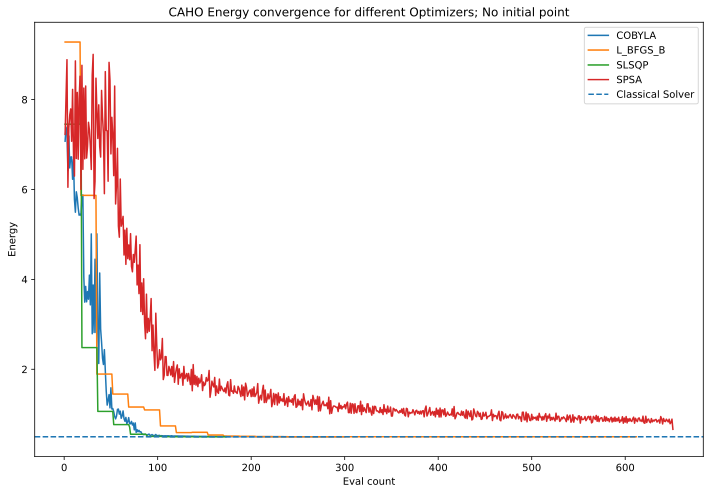

In [16]:
#CAQHO Statevector simulator 1 reps; 300 trials; no Init_point.

results_CAQHO=VQE_Run(vf,optimizers,qi,None,None,P_CAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", results_CAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",results_CAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",results_CAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(results_CAQHO[type(optimizer).__name__]['counts'],
               results_CAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CAHO Energy convergence for different Optimizers; No initial point')
pylab.legend(loc='upper right');

VQE Results for COBYLA : 0.4984991777216289
VQE Results for L_BFGS_B : 0.4984587749755994
VQE Results for SLSQP : 0.49956344514505446
VQE Results for SPSA : 8.296901839746582
Exact Result: 0.49845


Total Runtime: 0:00:01.256795
Runtime for  COBYLA : 0:00:00.280297
Runtime for  L_BFGS_B : 0:00:00.428320
Runtime for  SLSQP : 0:00:00.079161
Runtime for  SPSA : 0:00:00.469004


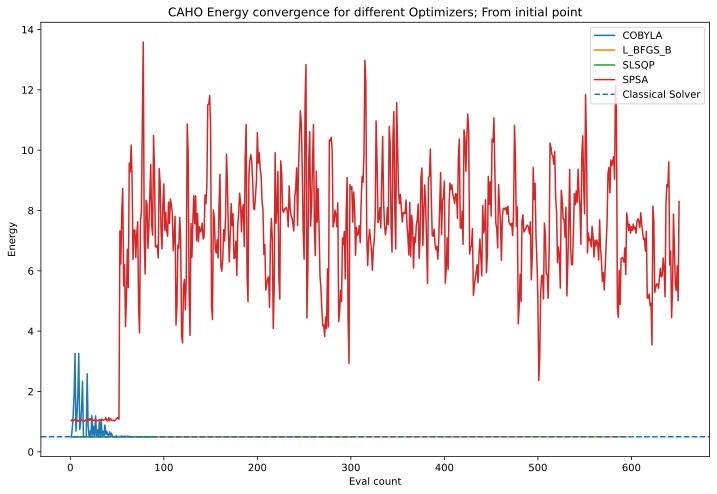

In [18]:
#CAQHO Statevector simulator 1 reps; 300 trials; Init_point.

results_CAQHO=VQE_Run(vf,optimizers,qi,None,results_QHO['L_BFGS_B']['opt_pt'],P_CAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", results_CAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",results_CAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",results_CAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(results_CAQHO[type(optimizer).__name__]['counts'],
               results_CAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CAHO Energy convergence for different Optimizers; From initial point')
pylab.legend(loc='upper right');

VQE Results for COBYLA : 0.5061866937166836
VQE Results for L_BFGS_B : 0.506081970333232
VQE Results for SLSQP : 0.5060814652913199
VQE Results for SPSA : 0.5363676646871599
Exact Result: 0.50608


Total Runtime: 0:00:01.707825
Runtime for  COBYLA : 0:00:00.265931
Runtime for  L_BFGS_B : 0:00:00.709917
Runtime for  SLSQP : 0:00:00.199147
Runtime for  SPSA : 0:00:00.532807


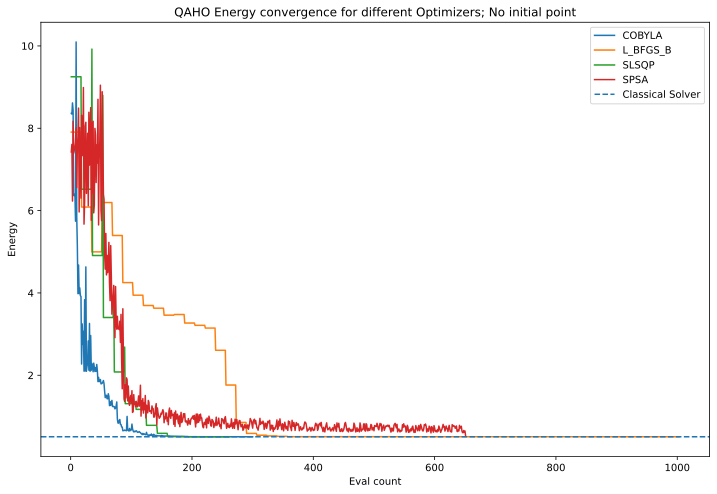

In [19]:
#QAQHO Statevector simulator 1 reps; 300 trials; no init_point.

results_QAQHO=VQE_Run(vf,optimizers,qi,None,None,P_QAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", results_QAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",results_QAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",results_QAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(results_QAQHO[type(optimizer).__name__]['counts'],
               results_QAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('QAHO Energy convergence for different Optimizers; No initial point')
pylab.legend(loc='upper right');

VQE Results for COBYLA : 0.5062156710649409
VQE Results for L_BFGS_B : 0.5060787162842245
VQE Results for SLSQP : 0.506227848191506
VQE Results for SPSA : 5.646088460483044
Exact Result: 0.50608


Total Runtime: 0:00:01.564875
Runtime for  COBYLA : 0:00:00.220327
Runtime for  L_BFGS_B : 0:00:00.664016
Runtime for  SLSQP : 0:00:00.055938
Runtime for  SPSA : 0:00:00.624587


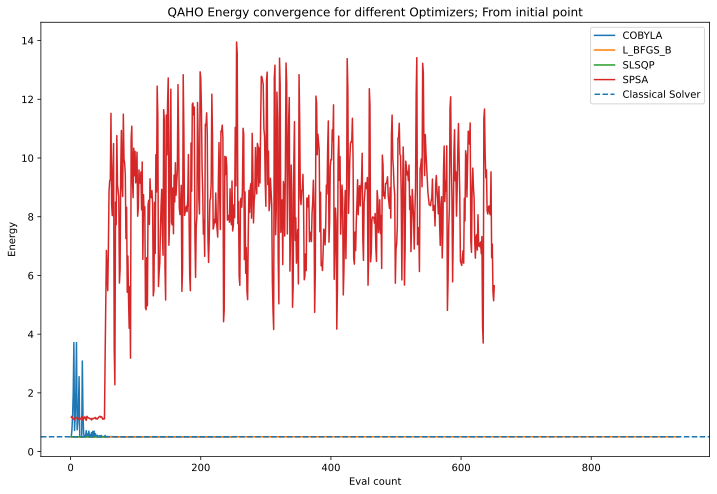

In [20]:
#QAQHO Statevector simulator 1 reps; 300 trials; init_point.

results_QAQHO=VQE_Run(vf,optimizers,qi,None,results_QHO['L_BFGS_B']['opt_pt'],P_QAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", results_QAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",results_QAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",results_QAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(results_QAQHO[type(optimizer).__name__]['counts'],
               results_QAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('QAHO Energy convergence for different Optimizers; From initial point')
pylab.legend(loc='upper right');

In [226]:
#define Quantum Instances, Variational Form, optimizers and gradients.
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin

seed = 62
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed) #Ideal Quantum Imstamce
nois_qi = QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

vf=EfficientSU2( #VAriational Form
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )

miter=300
optimizers = [COBYLA(maxiter=miter), L_BFGS_B(maxiter=miter), SLSQP(maxiter=miter), SPSA(maxiter=miter)]

gradients=[Gradient(grad_method='param_shift'),Gradient(grad_method='lin_comb'),Gradient(grad_method='fin_diff')]

VQE Results for COBYLA : 0.5712890625
VQE Results for L_BFGS_B : 0.6718750000000003
VQE Results for SLSQP : 1.41015625
VQE Results for SPSA : 0.5976562500000003
Exact Result: 0.50000


Total Runtime: 0:01:45.200638
Runtime for  COBYLA : 0:00:05.250544
Runtime for  L_BFGS_B : 0:01:12.678818
Runtime for  SLSQP : 0:00:13.314522
Runtime for  SPSA : 0:00:13.956733


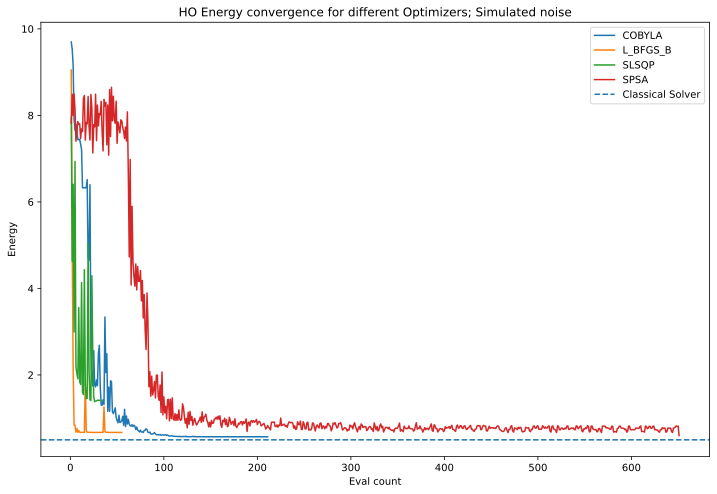

In [227]:
#QHO noisy simulator 1 reps; 300 trials.

noisy_results_QHO=VQE_Run(vf,optimizers,nois_qi,gradients[1],None,P_HOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", noisy_results_QHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",noisy_results_QHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",noisy_results_QHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(noisy_results_QHO[type(optimizer).__name__]['counts'],
               noisy_results_QHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('HO Energy convergence for different Optimizers; Simulated noise')
pylab.legend(loc='upper right');



VQE Results for COBYLA : 0.7578327275592535
VQE Results for L_BFGS_B : 6.921339617304596
VQE Results for SLSQP : 6.946945825708164
VQE Results for SPSA : 0.6487981878664806
Exact Result: 0.49845


Total Runtime: 0:02:59.836942
Runtime for  COBYLA : 0:00:39.386875
Runtime for  L_BFGS_B : 0:00:04.036611
Runtime for  SLSQP : 0:00:03.829255
Runtime for  SPSA : 0:02:12.584171


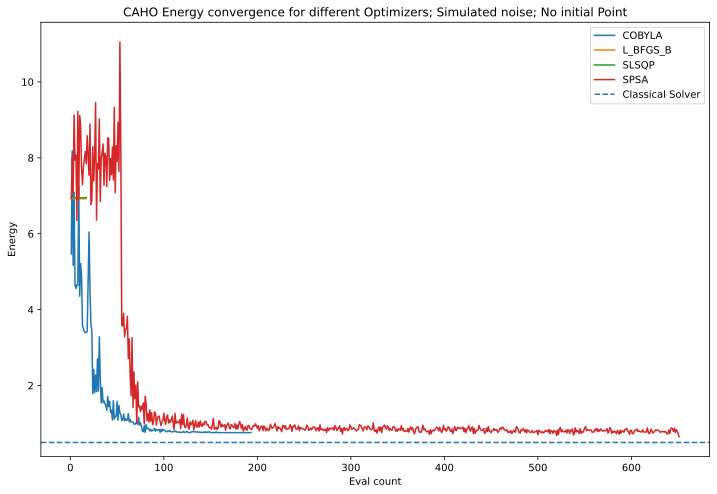

In [228]:
#CAQHO noisy simulator 1 reps; 300 trials; no Init_point.
noisy_results_CAQHO=VQE_Run(vf,optimizers,nois_qi,None,None,P_CAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", noisy_results_CAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",noisy_results_CAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",noisy_results_CAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(noisy_results_CAQHO[type(optimizer).__name__]['counts'],
               noisy_results_CAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CAHO Energy convergence for different Optimizers; Simulated noise; No initial Point')
pylab.legend(loc='upper right');



VQE Results for COBYLA : 0.5316019490688215
VQE Results for L_BFGS_B : 0.7811504904919799
VQE Results for SLSQP : 0.7811504904919799
VQE Results for SPSA : 1.8317639922088376
Exact Result: 0.49845


Total Runtime: 0:02:59.219981
Runtime for  COBYLA : 0:00:37.349214
Runtime for  L_BFGS_B : 0:00:03.547447
Runtime for  SLSQP : 0:00:03.398219
Runtime for  SPSA : 0:02:14.925086


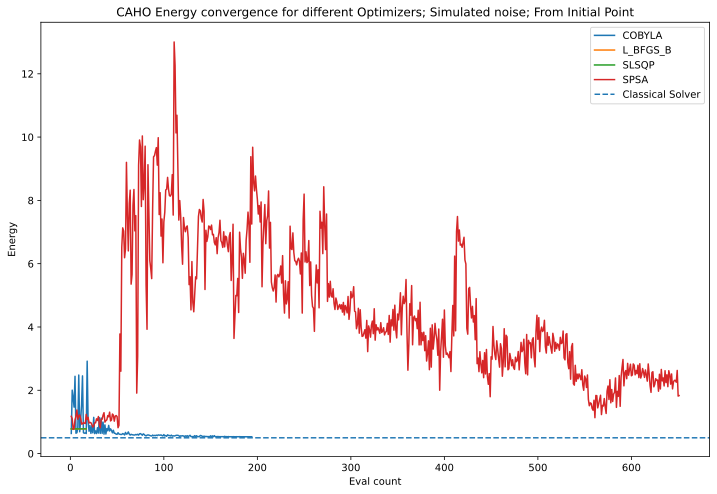

In [229]:
#CAQHO noisy simulator 1 reps; 300 trials; Init_point.
noisy_results_CAQHO=VQE_Run(vf,optimizers,nois_qi,None,noisy_results_QHO['COBYLA']['opt_pt'],P_CAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", noisy_results_CAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",noisy_results_CAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",noisy_results_CAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(noisy_results_CAQHO[type(optimizer).__name__]['counts'],
               noisy_results_CAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CAHO Energy convergence for different Optimizers; Simulated noise; From Initial Point')
pylab.legend(loc='upper right');




VQE Results for COBYLA : 0.6144071371013312
VQE Results for L_BFGS_B : 0.817287929963468
VQE Results for SLSQP : 0.817287929963468
VQE Results for SPSA : 1.1790904958245636
Exact Result: 0.50608


Total Runtime: 0:02:40.258820
Runtime for  COBYLA : 0:00:13.472714
Runtime for  L_BFGS_B : 0:00:02.031365
Runtime for  SLSQP : 0:00:01.825802
Runtime for  SPSA : 0:02:22.928924


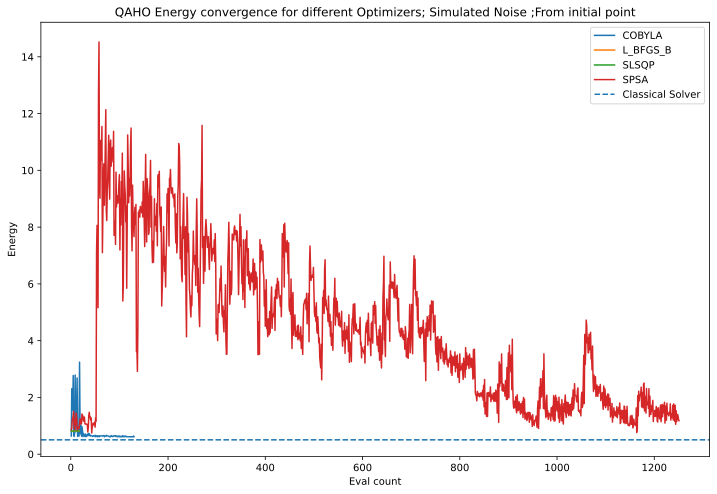

In [230]:
#QAQHO noisy simulator 1 reps; 300 trials; init_point.

miter=600
optimizers = [COBYLA(maxiter=miter), L_BFGS_B(maxiter=miter), SLSQP(maxiter=miter), SPSA(maxiter=miter)]

noisy_results_QAQHO=VQE_Run(vf,optimizers,nois_qi,None,noisy_results_QHO['COBYLA']['opt_pt'],P_QAHOE_OP) #Run VQE

#Print Results
for i,optimizer in enumerate(optimizers):
    print("VQE Results for",type(optimizer).__name__,":", noisy_results_QAQHO[type(optimizer).__name__]['eigenvalues'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("\n")

print ("Total Runtime:",noisy_results_QAQHO['Total Runtime'])
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",noisy_results_QAQHO[type(optimizer).__name__]['Runtime'])
    
#Plot Convergence
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(noisy_results_QAQHO[type(optimizer).__name__]['counts'],
               noisy_results_QAQHO[type(optimizer).__name__]['values'], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('QAHO Energy convergence for different Optimizers; Simulated Noise ;From initial point')
pylab.legend(loc='upper right');

In [31]:
#Using Real Devices. Setup QISKIT Runtime

#import Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

#set runtime backend
service = QiskitRuntimeService(channel="ibm_quantum")
runt_backend=service.backend("ibmq_manila")

service.backends(simulator=False, operational=True, min_num_qubits=5)

[<IBMBackend('ibmq_santiago')>,
 <IBMBackend('ibmq_bogota')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_manila')>]

In [40]:
#Running on a real device. SPSA 50 iter; Real Amplitudes; HO
from qiskit_nature.runtime import VQEClient

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def rt_callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
measurement_error_mitigation = True
store_intermediate=True
initial_point = np.random.random(vf.num_parameters)

optimizer = SPSA(maxiter=50)

vf=RealAmplitudes(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )

runtime_vqe = VQEClient(ansatz=vf,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend_manil,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

rt_result = runtime_vqe.compute_minimum_eigenvalue(P_HOE_OP)

Eigenvalue: (0.5991210937500003+0j)
Mean error: (0.07176946680587996+0j)
Total time taken: 5.91min

Median time of the iterations: 6.68s
Average time per iteration: 7.09s
Standard deviation: 3.96s


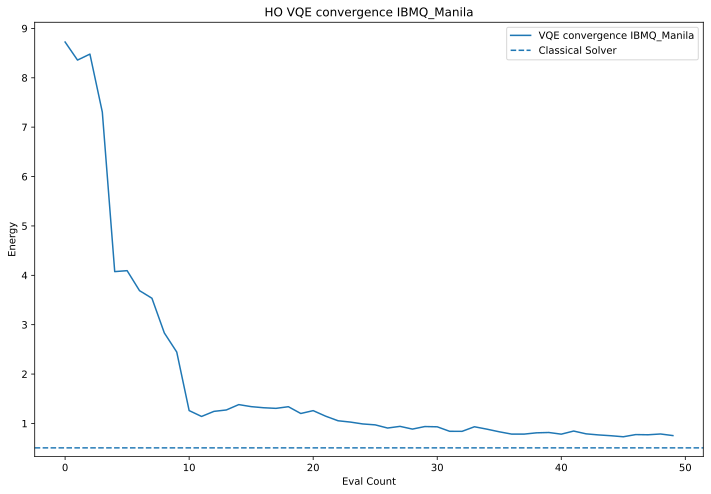

In [43]:
print('Eigenvalue:', rt_result.eigenvalue)
print('Mean error:', np.mean(intermediate_info['stddev']))

history = rt_result.optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Standard deviation: {np.std(runtimes):.2f}s')

pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='VQE convergence IBMQ_Manila')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence IBMQ_Manila')
pylab.legend(loc='upper right');

In [107]:
#Do VQE and return result and callback function

def VQE_RT(vf,optimizer,provider,backend,shots,initial_point,measurement_error_mitigation,store_intermediate,OP):
    
    q=vf.num_qubits
    results={}
 
    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }

    def rt_callback(nfev, parameters, energy, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['energy'].append(energy)
        intermediate_info['stddev'].append(stddev)
    
    runtime_vqe = VQEClient(ansatz=vf,
                            optimizer=optimizer,
                            initial_point=initial_point,
                            provider=provider,
                            backend=backend_manil,
                            shots=sh,
                            measurement_error_mitigation=measurement_error_mitigation,
                            callback=rt_callback,
                            store_intermediate=store_intermediate)
        
    results['result']= runtime_vqe.compute_minimum_eigenvalue(OP)
    results['intermediate info']= intermediate_info
                                                                
      
    return results

In [ ]:
#Setting Parameters for VQE

measurement_error_mitigation = True
store_intermediate=True

optimizers = [SPSA(maxiter=75),COBYLA(maxiter=75)]

vf=RealAmplitudes(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )
initial_point = np.random.random(vf.num_parameters)

Eigenvalue: (0.8740234375000002+0j)
Mean error: (0.07798858130051083+0j)
Total time taken: 8.39min

Median time of the iterations: 6.73s
Average time per iteration: 6.71s
Standard deviation: 0.80s


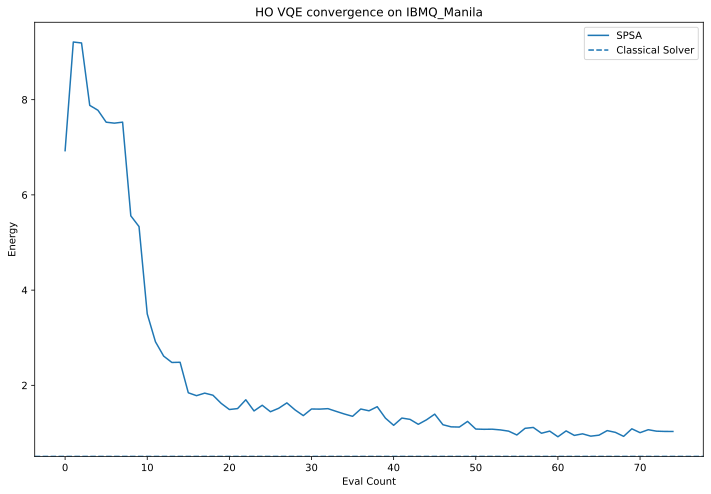

In [141]:
#HO VQE SPSA Optimizer

rt_results_SPSA=VQE_RT(vf,optimizers[0],provider,backend_manil,sh,initial_point,
                       measurement_error_mitigation,store_intermediate,P_HOE_OP)

print('Eigenvalue:', rt_results_SPSA['result'].eigenvalue)
print('Mean error:', np.mean(rt_results_SPSA['intermediate info']['stddev']))

history = rt_results_SPSA['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Standard deviation: {np.std(runtimes):.2f}s')

pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='SPSA')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence on IBMQ_Manila')
pylab.legend(loc='upper right');

In [ ]:
#HO VQE COBYLA Optimizer
rt_results_COBYLA=VQE_RT(vf,optimizers[1],provider,backend_manil,sh,initial_point,
                         measurement_error_mitigation,store_intermediate,P_HOE_OP)

print('Eigenvalue:', rt_results_COBYLA['result'].eigenvalue)
print('Mean error:', np.mean(rt_results_COBYLA['intermediate info']['stddev']))

#history = rt_results_COBYLA['result'].optimizer_history #COBYLA DOESn"T SUPPORT HISTORY

#loss = history['loss'] #
#timestamps = history['time']

#runtimes = np.concatenate(([0], np.diff(timestamps)))
#runtimes_in_min = runtimes / 60

print(f'Total time taken by optimizer: {rt_results_COBYLA['result']['optimizer_time']}min\n')

#print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
#print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
#print(f'Standard deviation: {np.std(runtimes):.2f}s')

#pylab.rcParams['figure.figsize'] = (12, 8)
#pylab.plot(loss, label='COBYLA')
#pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
#pylab.xlabel('Eval Count')
#pylab.ylabel('Energy')
#pylab.title('HO VQE convergence IBMQ_Manila')
#pylab.legend(loc='upper right');

VQE Results for SPSA : (0.6601562500000006+0j)
VQE Results for COBYLA : (6.748046874999999+0j)
Exact Result: 0.50000

Time taken for SPSA 14.66 minutes
Time taken for COBYLA 82.30 minutes
Median time of the iterations for SPSA:", 6.67s
Average time per iteration for SPSA: 6.68s
Iteration Standard deviation for SPSA: 0.92s


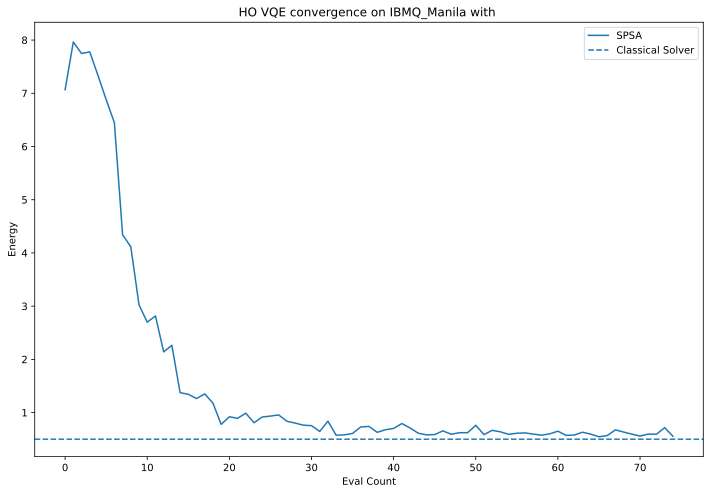

In [238]:
# So as not to have to run a new job every time i retrieve previous jobs here.

job_SPSA=provider.runtime.job('c9u2qo68u8mfr0d8u68g')
job_COBYLA=provider.runtime.job('c9u361u8u8mfr0d903gg')
result_SPSA=job_SPSA.result()
result_COBYLA=job_COBYLA.result()

results=[result_SPSA,result_COBYLA]
names=['SPSA','COBYLA']
for i,name in enumerate(names):
    print("VQE Results for",name,":", results[i]['eigenvalue'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}\n')


history_SPSA=result_SPSA['optimizer_history']
history_COBYLA=result_COBYLA['optimizer_history']
    
for i,name in enumerate(names):
    print(f'Time taken for {name} {results[i]["optimizer_time"]/60:.2f} minutes')
      
      
timestamps_SPSA = history_SPSA['time']
#timestamps_COBYLA = history_COBYLA['time'] #COBYLA has no history on current implementation
      
runtimes_SPSA = np.concatenate(([0], np.diff(timestamps_SPSA)))
runtimes_in_min_SPSA= runtimes_SPSA / 60
      
#runtimes_COBYLA = np.concatenate(([0], np.diff(timestamps_COBYLA)))
#runtimes_in_min_COBYLA= runtimes_COBYLA / 60
      
print(f'Median time of the iterations for SPSA:", {np.median(runtimes_SPSA):.2f}s')
print(f'Average time per iteration for SPSA: {np.mean(runtimes_SPSA):.2f}s')
print(f'Iteration Standard deviation for SPSA: {np.std(runtimes_SPSA):.2f}s')
#print(f'Median time of the iterations for COBYLA:", {np.median(runtimes_COBYLA):.2f}s')
#print(f'Average time per iteration for COBYLA: {np.mean(runtimes_COBYLA):.2f}s')
#print(f'Standard deviation for COBYLA: {np.std(runtimes_COBYLA):.2f}s')
    
loss_SPSA=history_SPSA['loss']
#loss_COBYLA=history_COBYLA['loss'] 

pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss_SPSA, label='SPSA')
#pylab.plot(loss_Cobyla, label='Cobyla')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence on IBMQ_Manila with ')
pylab.legend(loc='upper right');

In [153]:
#Setting parameters for VQE
measurement_error_mitigation = True
store_intermediate=True

optimizer = SPSA(maxiter=100)

vfs=[RealAmplitudes(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        ),
    EfficientSU2(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )
   ]

initial_point = np.random.random(vf.num_parameters)

Eigenvalue: (0.97412109375+0j)
Mean error: (0.095764253733959+0j)
Total time taken: 12.68min

Median time of the iterations: 6.71s
Average time per iteration: 7.61s
Iteration standard deviation: 8.81s


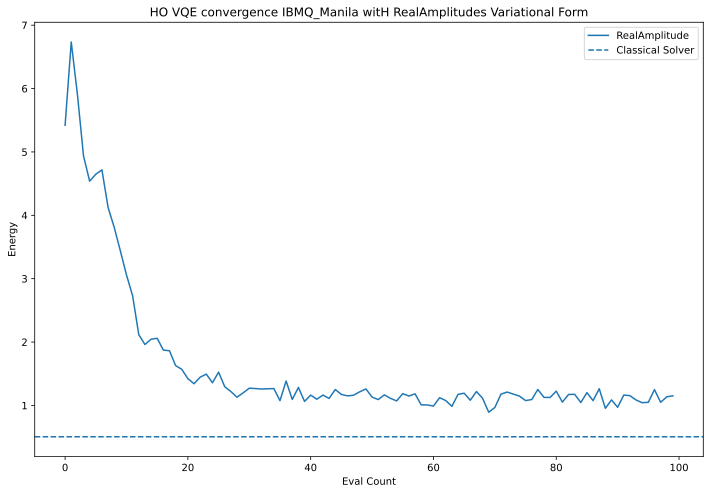

In [146]:
#HO Real Amplitudes Variational Form.

rt_results_RealAmp=VQE_RT(vfs[0],optimizer,provider,backend_manil,sh,initial_point,measurement_error_mitigation,store_intermediate,P_HOE_OP)

print('Eigenvalue:', rt_results_RealAmp['result'].eigenvalue)
print('Mean error:', np.mean(rt_results_RealAmp['intermediate info']['stddev']))

history = rt_results_RealAmp['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Iteration standard deviation: {np.std(runtimes):.2f}s')

pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='RealAmplitude')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence IBMQ_Manila witH RealAmplitudes Variational Form')
pylab.legend(loc='upper right');

Eigenvalue: (0.6767578124999998+0j)
Mean error: (0.04839099906774697+0j)
Total time taken: 11.29min

Median time of the iterations: 6.84s
Average time per iteration: 6.77s
Iteration standard deviation: 0.72s


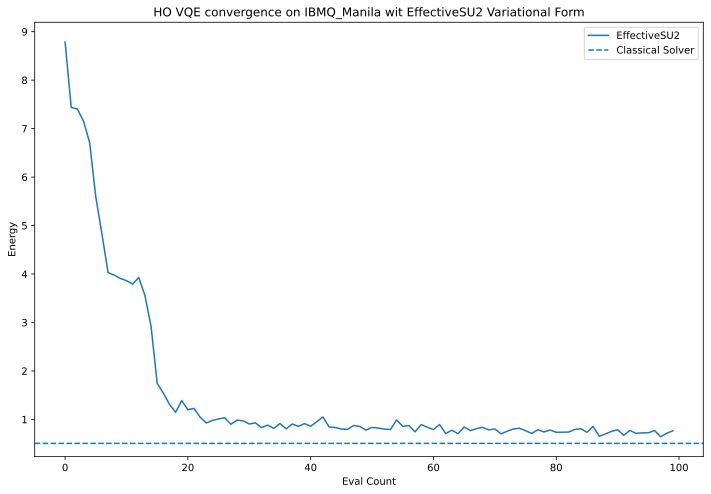

In [154]:
#HO EffSU2 Variational Form.
rt_results_EffSU2=VQE_RT(vfs[1],optimizer,provider,backend_manil,sh,initial_point,
                         measurement_error_mitigation,store_intermediate,P_HOE_OP)

print('Eigenvalue:', rt_results_EffSU2['result'].eigenvalue)
print('Mean error:', np.mean(rt_results_EffSU2['intermediate info']['stddev']))

history = rt_results_EffSU2['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Iteration standard deviation: {np.std(runtimes):.2f}s')

pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='EfficientSU2')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence on IBMQ_Manila wit EfficientSU2 Variational Form')
pylab.legend(loc='upper right');

VQE Results for Real Amplitudes : (0.6328124999999997+0j)
VQE Results for EfficientSU2 : (0.6718749999999998+0j)
Exact Result: 0.50000

Time taken for Real Amplitudes : 13.981180691719056 minutes
Median time of the iterations for Real Amplitudes: 6.68s
Average time per iteration for Real Amplitudes: 6.72s
Iteration standard deviation for Real Amplitudes: 0.80s

Time taken for EfficientSU2 : 13.440128628412882 minutes
Median time of the iterations for EfficientSU2: 6.69s
Average time per iteration for EfficientSU2: 6.66s
Iteration standard deviation for EfficientSU2: 0.79s



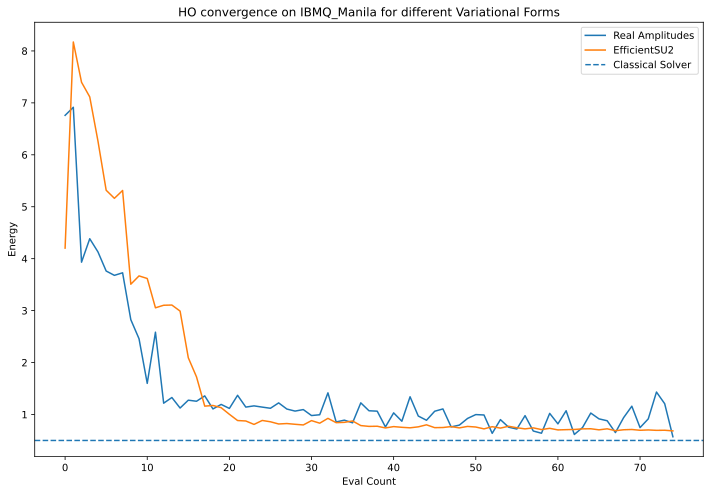

In [237]:
# So as not to run a new job every time i retrieve previous jobs here.

job_RealAmp=provider.runtime.job('c9u4s7kj5t1ttvd4nhh0')
job_EffSU2=provider.runtime.job('c9u558cj5t1ttvd4obmg')

results=[job_RealAmp.result(),job_EffSU2.result()]
names=['Real Amplitudes','EfficientSU2']
for i,name in enumerate(names):
    print("VQE Results for",name,":", results[i]['eigenvalue'])
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}\n')

history={}
timestamps=[]
runtimes=[]
runtimes_in_min=[]
loss=[[]for _ in enumerate(names)]
for i, name in enumerate(names):
    history=results[i]['optimizer_history']
    print("Time taken for",name,":", results[i]['optimizer_time']/60,'minutes')
    timestamps = history['time']
    runtimes = np.concatenate(([0], np.diff(timestamps)))
    runtimes_in_min= runtimes / 60
    print(f'Median time of the iterations for {name}: {np.median(runtimes):.2f}s')
    print(f'Average time per iteration for {name}: {np.mean(runtimes):.2f}s')
    print(f'Iteration standard deviation for {name}: {np.std(runtimes):.2f}s\n')
    loss[i]=history['loss']
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i, name in enumerate(names):
    pylab.plot(loss[i], label=name)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO convergence on IBMQ_Manila for different Variational Forms')
pylab.legend(loc='upper right');
    



In [231]:
#Setting parameters for VQE
measurement_error_mitigation = True
store_intermediate=True

optimizer = SPSA(maxiter=150)


vf=EfficientSU2(
        num_qubits=q,
        reps=1,
        entanglement='linear'
        )

initial_point = np.random.random(vf.num_parameters)

VQE Results : (2.1977539062500004+0j)
Mean error: (0.08392593152666948+0j)
Exact Result: 0.50000
Time taken: 1416.5490980148315
Median time of the iterations: 6.70s
Average time per iteration: 6.95s
Iteration standard deviation: 2.13s
Total time taken: 17.38min



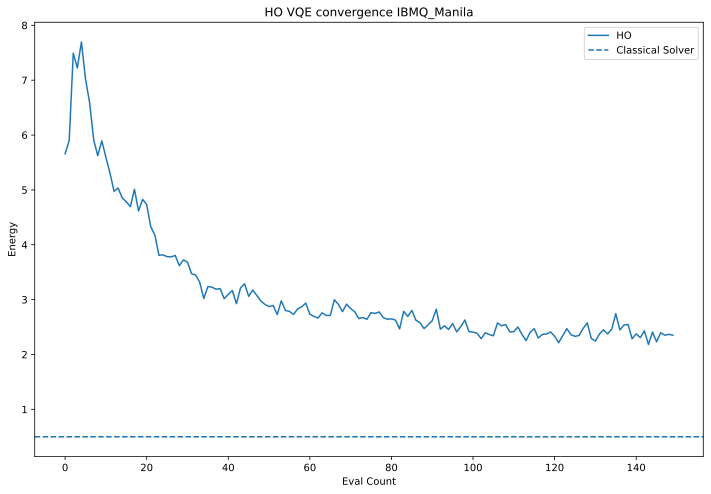

In [232]:
#QHO; IBMQ Manila; SPSA 150 iter; EfficientSU2;

rt_results_HOE=VQE_RT(vf,optimizer,provider,backend_manil,sh,initial_point,
                      measurement_error_mitigation,store_intermediate,P_HOE_OP)
print("VQE Results :",rt_results_HOE['result'].eigenvalue)

np.mean(rt_results_HOE['intermediate info']['stddev'])
print('Mean error:', np.mean(rt_results_HOE['intermediate info']['stddev']))
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("Time taken:", rt_results_HOE['result'].optimizer_time)

history = rt_results_HOE['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Iteration standard deviation: {np.std(runtimes):.2f}s')
    
print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')


pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='HO')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('HO VQE convergence IBMQ_Manila')
pylab.legend(loc='upper right');

VQE Results : (1.1769437025283296+0j)
Mean error: (0.10820802324105837+0j)
Exact Result: 0.49845
Time taken: 2745.159175634384
Median time of the iterations: 19.16s
Average time per iteration: 19.83s
Iteration standard deviation: 6.27s
Total time taken: 33.05min



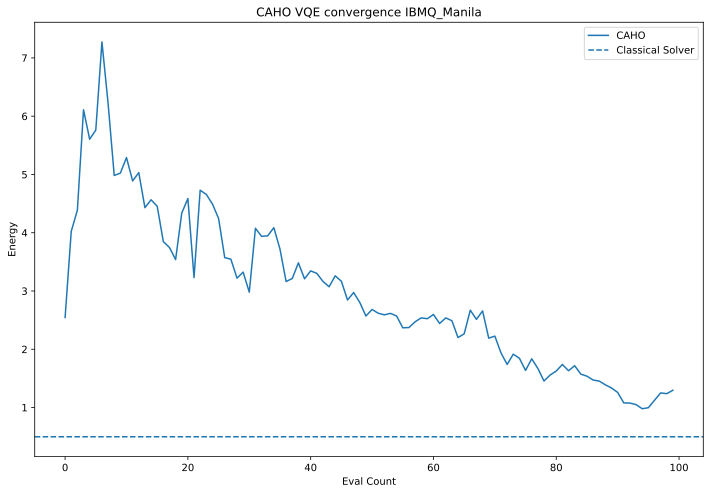

In [233]:
#CAHO; IBMQ Manila; SPSA 200 iter; EfficientSU2;

optimizer = SPSA(maxiter=100)

initial_point=rt_results_HOE['result'].optimal_point
#initial_point=job_QHO.result()['optimal_point']

rt_results_CAHOE=VQE_RT(vf,optimizer,provider,backend_manil,sh,initial_point,
                        measurement_error_mitigation,store_intermediate,P_CAHOE_OP)
print("VQE Results :",rt_results_CAHOE['result'].eigenvalue)

np.mean(rt_results_CAHOE['intermediate info']['stddev'])
print('Mean error:', np.mean(rt_results_CAHOE['intermediate info']['stddev']))
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("Time taken:", rt_results_CAHOE['result'].optimizer_time)

history = rt_results_CAHOE['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Iteration standard deviation: {np.std(runtimes):.2f}s')
    
print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')


pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='CAHO')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('CAHO VQE convergence IBMQ_Manila')
pylab.legend(loc='upper right');

VQE Results : (0.8742773441373632+0j)
Mean error: (0.08807023786356681+0j)
Exact Result: 0.50608
Time taken: 1851.9562866687775
Median time of the iterations: 12.51s
Average time per iteration: 13.60s
Iteration standard deviation: 8.60s
Total time taken: 22.67min



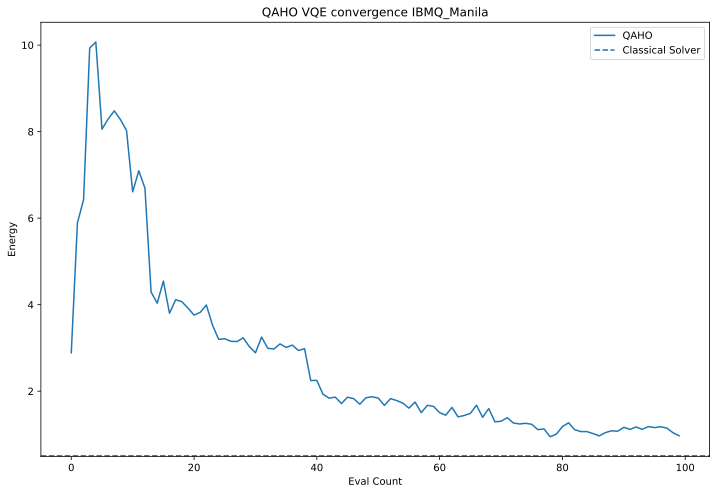

In [234]:
#QAHO; IBMQ Manila; SPSA 200 iter; EfficientSU2;

optimizer = SPSA(maxiter=100)

initial_point=rt_results_HOE['result'].optimal_point
#initial_point=job_QHO.result()['optimal_point']

rt_results_QAHOE=VQE_RT(vf,optimizer,provider,backend_manil,sh,initial_point,
                        measurement_error_mitigation,store_intermediate,P_QAHOE_OP)
print("VQE Results :",rt_results_QAHOE['result'].eigenvalue)

np.mean(rt_results_QAHOE['intermediate info']['stddev'])
print('Mean error:', np.mean(rt_results_QAHOE['intermediate info']['stddev']))
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

print("Time taken:", rt_results_QAHOE['result'].optimizer_time)

history = rt_results_QAHOE['result'].optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Iteration standard deviation: {np.std(runtimes):.2f}s')
    
print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')


pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(loss, label='QAHO')
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('QAHO VQE convergence IBMQ_Manila')
pylab.legend(loc='upper right');

VQE Result for QHO : (0.5341796875000006+0j)
Exact Result for QHO: 0.50000

VQE Result for CAHO : (0.8479038404449345+0j)
Exact Result for CAHO: 0.49845

VQE Result for QAHO : (0.8505859374999993+0j)
Exact Result for QAHO: 0.50608

Time taken for QHO : 59.52917331457138 minutes
Median time of the iterations for QHO: 6.88s
Average time per iteration for QHO: 7.11s
Standard deviation for QHO: 2.73s

Time taken for CAHO : 44.77662808497747 minutes
Median time of the iterations for CAHO: 19.09s
Average time per iteration for CAHO: 20.21s
Standard deviation for CAHO: 9.77s

Time taken for QAHO : 16.21731925010681 minutes
Median time of the iterations for QAHO: 6.65s
Average time per iteration for QAHO: 6.65s
Standard deviation for QAHO: 0.68s



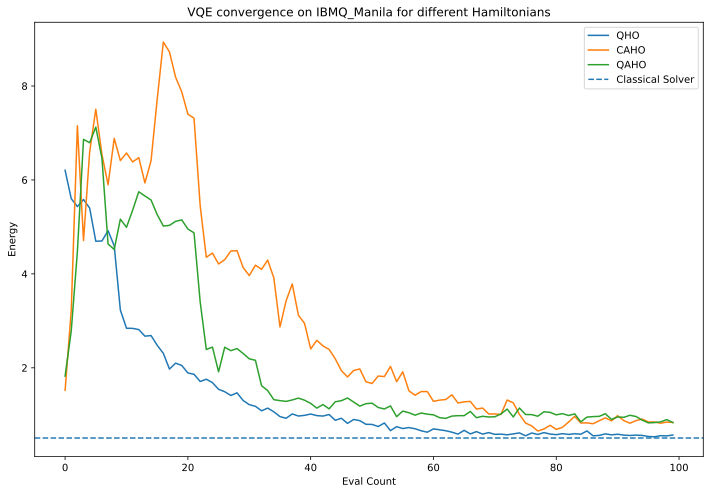

In [138]:
#retrieving previous best jobs so as not to run VQE everytime

job_QHO=provider.runtime.job('c9u8vlrf2jb93li7phvg')
job_CAHO=provider.runtime.job('c9ucd2jf2jb93li81g20')
job_QAHO=provider.runtime.job('c9uceom8u8mfr0d9onb0')


results=[job_QHO.result(),job_CAHO.result(),job_QAHO.result()]
names=['QHO','CAHO','QAHO']
operators=[P_HOE_OP,P_CAHOE_OP,P_QAHOE_OP]
for i,name in enumerate(names):
    print("VQE Result for",name,":", results[i]['eigenvalue'])
    exact_solution = npme.compute_minimum_eigenvalue(operator=operators[i])
    print(f'Exact Result for {name}: {exact_solution.eigenvalue.real:.5f}\n')

history={}
timestamps=[]
runtimes=[]
runtimes_in_min=[]
loss=[[]for _ in enumerate(names)]
for i, name in enumerate(names):
    history=results[i]['optimizer_history']
    print("Time taken for",name,":", results[i]['optimizer_time']/60,'minutes')
    timestamps = history['time']
    runtimes = np.concatenate(([0], np.diff(timestamps)))
    runtimes_in_min= runtimes / 60
    print(f'Median time of the iterations for {name}: {np.median(runtimes):.2f}s')
    print(f'Average time per iteration for {name}: {np.mean(runtimes):.2f}s')
    print(f'Standard deviation for {name}: {np.std(runtimes):.2f}s\n')
    loss[i]=history['loss']
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i, name in enumerate(names):
    pylab.plot(loss[i], label=name)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval Count')
pylab.ylabel('Energy')
pylab.title('VQE convergence on IBMQ_Manila for different Hamiltonians')
pylab.legend(loc='upper right');
    



In [56]:
import qiskit.tools.jupyter
%qiskit_version_table